## Electricity price prediction using linear regression

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For visualizations we will use ggplot stlye and Century Gothic as font family
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Century Gothic' 

In [2]:
# Import the datasets 
prices = pd.read_csv('./Datasets/Average_retail_price_of_electricity_California_monthly.csv')
generation = pd.read_csv('./Datasets/Net_generation.csv')
users = pd.read_csv('./Datasets/Number_of_customers.csv')

### Data exploration

In [3]:
# Show first rows of dataset
prices.head()

,Month,residential cents per kilowatthour,commercial cents per kilowatthour,industrial cents per kilowatthour
0,01/11/2023,29.41,23.14,18.55
1,01/10/2023,26.72,24.47,20.41
2,01/09/2023,29.99,27.34,20.72
3,01/08/2023,29.84,28.11,22.05
4,01/07/2023,29.38,26.64,20.92


In [4]:
# Show first rows of dataset
generation.head()

,Month,Wind thousand MWh,Coal thousand MWh,Geothermal thousand MWh,Biomass thousand MWh,Natural gas thousand MWh,Nuclear thousand MWh,Hydroelectric thousand MWh,Solar thousand MWh
0,01/11/2023,36807.77940,51229.15606,1409.60572,3881.44002,135211.8714,62257.644,18100.70117,15212.96653
1,01/10/2023,36422.46732,50954.14922,1414.29645,3499.23867,140961.7289,61402.632,18085.96893,20176.74911
2,01/09/2023,28193.29153,60005.67580,1350.69974,3732.57919,164466.3568,65559.710,16496.04043,22192.58066
3,01/08/2023,28504.16694,78184.50094,1340.51885,4243.62244,199993.0422,69744.023,21145.86624,25350.26673
4,01/07/2023,27867.90946,78909.85665,1303.27473,4170.15204,200506.7592,69887.588,21237.80849,26538.55725


In [5]:
# Show first rows of dataset
users.head()

,Month,commercial users,residential users,industrial users
0,01/11/2023,19306577,141052683,1067082
1,01/10/2023,19094390,141275989,1085349
2,01/09/2023,19336543,140885018,1091596
3,01/08/2023,19371824,141680588,1108708
4,01/07/2023,19325933,140708682,1090062


In [6]:
# Join and build just one dataframe with all the information
regression_df = prices.merge(generation, on='Month')
regression_df = regression_df.merge(users, on='Month')

In [7]:
# Drop the columns we dont need
regression_df.drop(columns=['Month', 'commercial cents per kilowatthour', 'industrial cents per kilowatthour', 
                 'commercial users', 'industrial users'], axis=1, inplace=True)

# Rename columns in the new dataframe
new_columns = {
    'residential cents per kilowatthour': 'Price cents/kWh',
    'Wind thousand MWh': 'Wind TWh',
    'Coal thousand MWh': 'Coal TWh', 
    'Geothermal thousand MWh': 'Geothermal TWh', 
    'Biomass thousand MWh': 'Biomass TWh',
    'Natural gas thousand MWh': 'Natural gas TWh', 
    'Nuclear thousand MWh': 'Nuclear TWh',
    'Hydroelectric thousand MWh': 'Hydroelectric TWh',
    'Solar thousand MWh': 'Solar TWh',
    'residential users': 'Users qty (Millions)'
}
regression_df = regression_df.rename(columns=new_columns)

In [8]:
# Apply new scale and show the dataframe updated
regression_df['Users qty (Millions)'] = regression_df['Users qty (Millions)'].apply(lambda x:x/1e6)
regression_df.iloc[:, 1:9] = regression_df.iloc[:, 1:9].apply(lambda x:x/1e3)
regression_df.head()

,Price cents/kWh,Wind TWh,Coal TWh,Geothermal TWh,Biomass TWh,Natural gas TWh,Nuclear TWh,Hydroelectric TWh,Solar TWh,Users qty (Millions)
0,29.41,36.807779,51.229156,1.409606,3.881440,135.211871,62.257644,18.100701,15.212967,141.052683
1,26.72,36.422467,50.954149,1.414296,3.499239,140.961729,61.402632,18.085969,20.176749,141.275989
2,29.99,28.193292,60.005676,1.350700,3.732579,164.466357,65.559710,16.496040,22.192581,140.885018
3,29.84,28.504167,78.184501,1.340519,4.243622,199.993042,69.744023,21.145866,25.350267,141.680588
4,29.38,27.867909,78.909857,1.303275,4.170152,200.506759,69.887588,21.237808,26.538557,140.708682


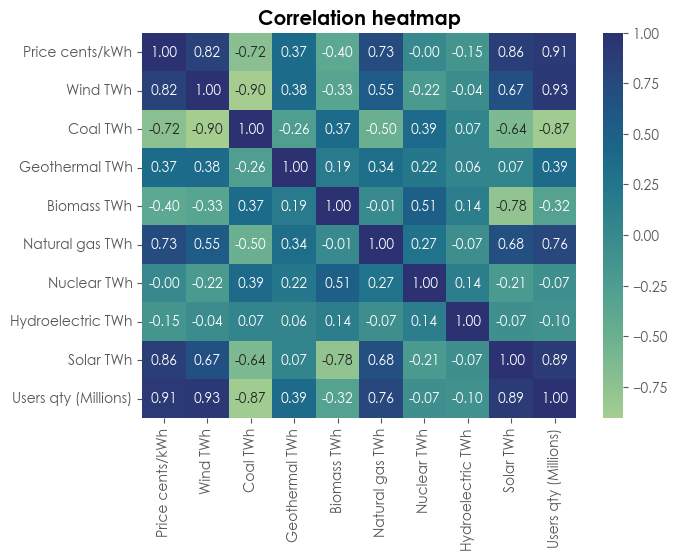

In [9]:
# First visualization. Show the correlation heatmap with available columns
plt.figure(figsize=(7, 5))
sns.heatmap(regression_df[regression_df.columns].corr(), annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation heatmap', fontweight='bold')
plt.show()

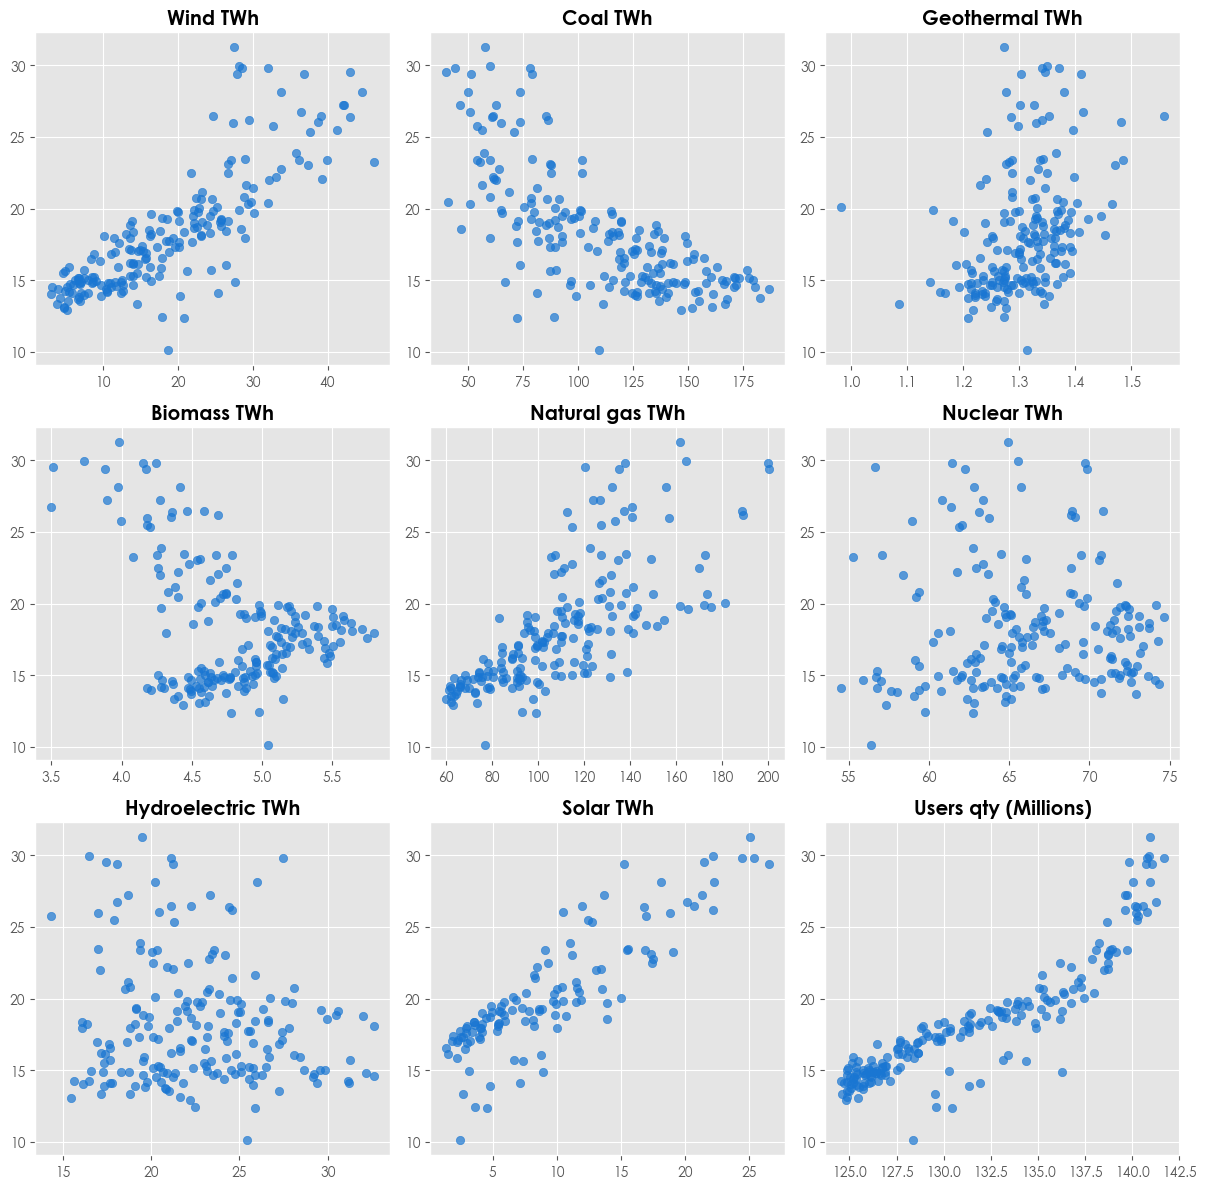

In [10]:
# Lets visualize those correlations between the electricity generated and the price
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()

for i in range(1, len(regression_df.columns)):
    axs[i-1].scatter(regression_df[regression_df.columns[i]], regression_df['Price cents/kWh'], color='#1976D2', alpha=0.7)
    axs[i-1].set_title(regression_df.columns[i], fontweight='bold')

plt.tight_layout()
plt.show()

## Creating the model

### 1. Simple Linear Regression

In [11]:
# Create a simple linear regression by choosing only one variable
# In this case the users qty columns shows more correlation to price
X = regression_df['Users qty (Millions)']
y = regression_df['Price cents/kWh']

In [12]:
# Calculate Simple linear regression with estimated coefficients
y_mean = y.mean()
X_mean = X.mean()

theta_num = 0
theta_den = 0

for i in range(len(X)):
    theta_num += (y[i] - y_mean) * (X[i] - X_mean)
    theta_den += (X[i] - X_mean)**2
    

theta_1 = theta_num / theta_den
theta_0 = y_mean - theta_1 * X_mean

y_prediccion = theta_0 + theta_1*X
print(f'Linear Regression equation: {theta_0:.2f} + {theta_1:.6f} X1')

Linear Regression equation: -78.77 + 0.738535 X1


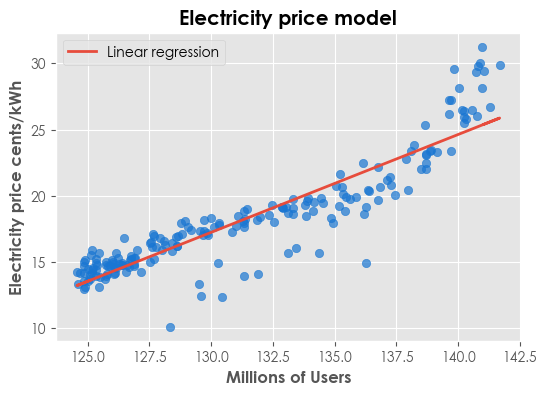

In [13]:
# Show visualization
plt.figure(figsize=(6, 4))
plt.scatter(X, y, color='#1976D2', alpha=0.7)
plt.plot(X, y_prediccion, color='#E74C3C', label='Linear regression', linewidth=2)
plt.title('Electricity price model', fontweight='bold')
plt.xlabel('Millions of Users', fontweight='bold')
plt.ylabel('Electricity price cents/kWh', fontweight='bold')
plt.legend()
plt.show()

In [14]:
# Calculate the model accuracy
SSR = np.sum((y - y_prediccion)**2)
SST = np.sum((y - y_mean)**2)
r2 = (1 - (SSR/SST))*100
print(f'The model accuracy is: {r2:.2f}%')

The model accuracy is: 82.10%


### 2. Linear Regression: Matrix form

In [15]:
# Now we will build a multiple linear regression model
# So, get the columns with more correlation and build a multiple regression model
X = regression_df[['Wind TWh', 'Coal TWh', 
              'Geothermal TWh', 'Biomass TWh',
              'Natural gas TWh', 'Users qty (Millions)']]
y = regression_df['Price cents/kWh']

In [16]:
# To scale all the predictor variables use standardization (Z-Score)
mean_values_X = X.mean()
std_dev_values_X = X.std()
X_standardized = (X - mean_values_X) / std_dev_values_X

In [17]:
# Apply the linnear equation matrix form
X_b = np.c_[np.ones((len(X_standardized), 1)), X_standardized]
theta_best = np.linalg.inv((X_b.T.dot(X_b))).dot(X_b.T).dot(y)
y_prediccion = X_b.dot(theta_best)

In [18]:
# Show all coefficients for multiple linear regression
for i in range(len(theta_best)):
    print(f'Theta{[i]} coefficient: {theta_best[i]:.5f}')

Theta[0] coefficient: 18.29188
Theta[1] coefficient: 0.74117
Theta[2] coefficient: 1.34272
Theta[3] coefficient: 0.28281
Theta[4] coefficient: -0.90301
Theta[5] coefficient: 0.62565
Theta[6] coefficient: 3.48552


In [19]:
# Calculate the model accuracy
mse = np.mean((y_prediccion - y)**2)
total_variability = np.var(y)
explained_variability = total_variability - mse
r2 = explained_variability / total_variability

print(f'The model accuracy is: {r2*100:.2f}%')

The model accuracy is: 86.89%


#### 2.1 Model visualization

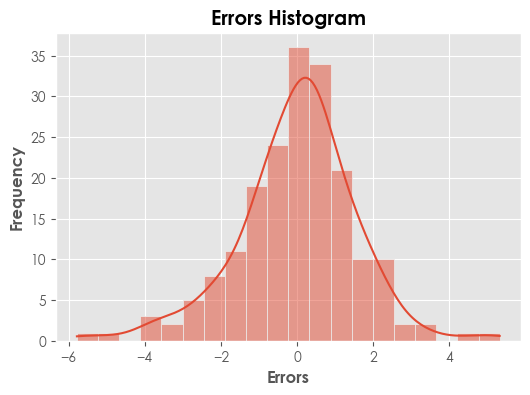

In [20]:
# Because it is difficult to visualize multiple linear regression we can take a look at the errors
# Calculate all errors in the model
errors = y - y_prediccion

# Errors Histogram
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True)
plt.title('Errors Histogram', fontweight='bold')
plt.xlabel('Errors', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

#### 2.2 Make predictions using this model

In [21]:
# Build a dataframe with new information and make 2 predictions using the model
prediction_df = pd.DataFrame({
    'Wind TWh': [36.807779, 36.422467], 
    'Coal TWh': [51.229156, 50.954149], 
    'Geothermal TWh': [1.409606, 1.414296], 
    'Biomass TWh': [3.881440, 3.499239],
    'Natural gas TWh': [135.211871, 140.961729], 
    'Users qty (Millions)': [141.052683, 141.275989]
})

# Need to scale this new dataframe
X_standardized_new = (prediction_df - mean_values_X) / std_dev_values_X
X_new_predictors = np.c_[np.ones((len(X_standardized_new), 1)), X_standardized_new]
# Using our coefficients and the new information (predictors) make a new prediction
y_new_prediction = X_new_predictors.dot(theta_best)

In [22]:
# Add the predictions to the dataframe and visualize
prediction_df_scikit = prediction_df.copy()
prediction_df['Prediction cents/kWh'] = y_new_prediction
prediction_df

,Wind TWh,Coal TWh,Geothermal TWh,Biomass TWh,Natural gas TWh,Users qty (Millions),Prediction cents/kWh
0,36.807779,51.229156,1.409606,3.881440,135.211871,141.052683,26.608730
1,36.422467,50.954149,1.414296,3.499239,140.961729,141.275989,27.628208


### 3. Linear Regression using Scikit Learn

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Get the columns with more correlation and build a multiple regression
X = regression_df[['Wind TWh', 'Coal TWh', 
              'Geothermal TWh', 'Biomass TWh',
              'Natural gas TWh', 'Users qty (Millions)']]
y = regression_df['Price cents/kWh']

# Split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale (Standardization) X matrix
scaler_X = StandardScaler()

# Scale train and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Build the linear regression model
modelo = LinearRegression()

# Make the train data fit to the model
modelo.fit(X_train_scaled, y_train)

# Now, make the predictions for each predictor value
y_pred = modelo.predict(X_test_scaled)

# Calculate MSE and R^2 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f'Intercept: {modelo.intercept_:.4f}')
print(f'Coefficients: {modelo.coef_}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Model accuracy (R^2): {r2*100:.3f}%')

Intercept: 18.2226
Coefficients: [ 0.64346391  1.34110669  0.40133153 -1.00625135  0.52222422  3.60196122]
Mean Squared Error (MSE): 1.9934
Model accuracy (R^2): 87.764%


In [24]:
# Use the same scaler for the new data points
X_scaled_new = scaler_X.transform(prediction_df_scikit)

# Make new predictions using the trained model
y_pred_scikit = modelo.predict(X_scaled_new)

# Add the predictions to the dataframe and visualize
prediction_df_scikit['Prediction cents/kWh'] = y_pred_scikit
prediction_df_scikit

,Wind TWh,Coal TWh,Geothermal TWh,Biomass TWh,Natural gas TWh,Users qty (Millions),Prediction cents/kWh
0,36.807779,51.229156,1.409606,3.881440,135.211871,141.052683,26.817592
1,36.422467,50.954149,1.414296,3.499239,140.961729,141.275989,27.923892
